# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Описание услуг:

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


In [1]:
# Импорт библиотек
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn import preprocessing

from catboost import CatBoostClassifier

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 270223

## Анализ данных

In [2]:
# Выгрузка данных о контрактах
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
# Просмотр первых 5 строк
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# Общая информация
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
# Проверка на дубликаты
contract.duplicated().sum()

0

В датафрейме отсутствуют пропуски, нет явных дубликатов, типы признаков нужно будет поменять BeginDate на date и TotalCharges на float, так же стоит изучить атрибуты MonthlyCharges, TotalCharges, EndDate с помощью графиков. 

В датафрейме про данные из контрактов указаны признаки:
- customerID - ID клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами
- Type - типы оплаты
- PaperlessBilling - эелектронный платежный документ
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего трат

In [6]:
# Выгрузка персональных данных
personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
personal.duplicated().sum()

0

В датафрейме с персональной информацией нет пропусков и явных дубликатов, все типы данных верны. Нужно будет построит график по каждому признаку кроме costomerID и исследовать их, т.к. они могут быть значимыми. 

Представленные атрибуты:
- customerID
- gender - гендр
- SeniorCitizen - наличие пенсионного статуса по возрасту
- Partner - наличие супруга(и)
- Dependents - наличие иждевенцев

In [10]:
# Выгрузка данных о интернете
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
internet.duplicated().sum()

0

В этом датафрейме так же нет пропусков и явных дубликатов, все типы данных верны. Сразу видна разница в количестве строк, в прошлых датафреймах их было на 1526 больше, скорее всего есть пользователи, которые не пользуются интернетом. В этой таблицы представлены данные о провайдере и использование дополнительных услуг, которые описывались в начале проекта. Так же построим для каждого из признаков графики и исследуем их по отдельности.

In [14]:
# Выгрузка данных о наличии возможности ведения параллельных линий во время звонка
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [15]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
phone.duplicated().sum()

0

Снова ни одного пропуска и ни одного дубликата, типы данных верны. В этот раз можно сказать, что телефонной связью пользуются тоже не все, 682 клиента видимо пользуются лишь интернет услугами. В этом датафрейме информация о том, может ли пользователь вести параллельные линии во время звонка. Так же построим график и исследуем данный признак.

# План проекта 

Для успешного написания данного проекта нужно:
- поменять некоторые типы данных
- проанализировать практически каждый признак с помощью построения графиков и их анализа
- объединить датафреймы левым соединением к таблице contract, все пропуски заменить на 'No', можем себе позволить такую замену т.к. пропуски означают то, что клиент не пользуется данной услугой
- создать target из столбца EndDate в contract(все значения равные 'No' заменить на 0, остальное на 1)
- проанализировать признаки на мультиколлинеарсность
- если будут выявлены ненужные столбцы, их нужно будет удалить
- проверить дисбаланс классов в целевом признаке
- разделить на выборки наш датафрейм (обучающая и тестовая в соотношении 3:1)
- провести кодирование данных с помощью OHE для текста и StandardScaler для числовых переменных
- рассмотрим модели CatBoost, LinearRegression и RandomForest
- подобрать гиперпараметры с помощью GreadSearchCV
- вывести на тест лучшею модель по результатам кросс-валидации(по метрике AUC_ROC)
- достигнуть значение метрики не меньше 0.85
- построить ROC-кривую, матрицу ошибок и провести анализ важности признаков
- написать отчет о проделанной работе

Вопросов по проекту нет.

## Исследовательский анализ данных, предобработка.

In [18]:
# Поменяем типы данных
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce') 
contract.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


В признаке TotalCharges остались пропуски, замена типа происходила с помощью параметра errors который игнорировал строки без чисел, логично будет заменить такие пропусски на 0

In [19]:
contract = contract.fillna(0)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


In [20]:
# Посмотрим какие строки в TotalChrges у нас равны 0
contract.loc[contract['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


Возможно данные по сумме потраченных средств за все время еще не обновились для этих строк, можно вычислить их. В типы договора указано, что абонент платит за 2 года сразу и в одной строке за 1, можно умножить месячные затраты на 24 и 12 соответственно.

In [21]:
contract.loc[(contract['TotalCharges'] == 0) & (contract['Type'] == 'Two year'),
             'TotalCharges'] = contract['MonthlyCharges'] * 24
contract.loc[(contract['TotalCharges'] == 0) & (contract['Type'] == 'One year'),
             'TotalCharges'] = contract['MonthlyCharges'] * 12
contract['TotalCharges'].min()

18.8

Теперь нулей нет.

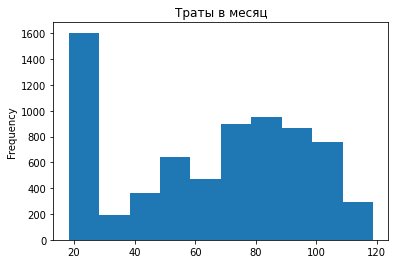

In [22]:
# Проанализиреум признаки, начнем с MonthlyCharges и TotalCharges
contract['MonthlyCharges'].plot(kind='hist', title='Траты в месяц');

Средняя месячная плата находится в районе 20-30, так же есть всплески в районе 70-110. 

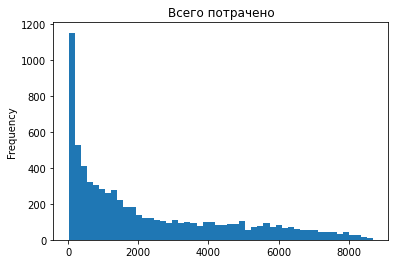

In [23]:
contract['TotalCharges'].plot(kind='hist', title='Всего потрачено', bins=50);

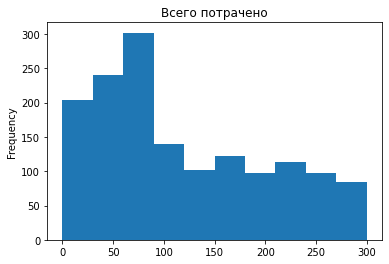

In [24]:
# Уменьшим масштаб
contract['TotalCharges'].plot(kind='hist', title='Всего потрачено', range=(0, 300));

В среднем потраченные на услуги деньги находятся в промежутке от 15 до 700 и доходят до 9000.

Рассмотрим признаки Type, PaperlessBilling, PaymentMethod.

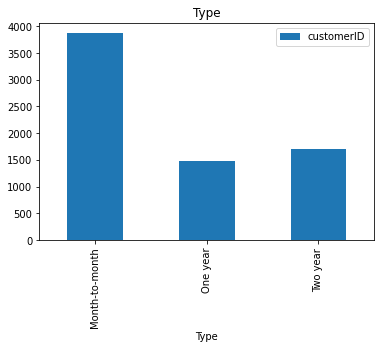

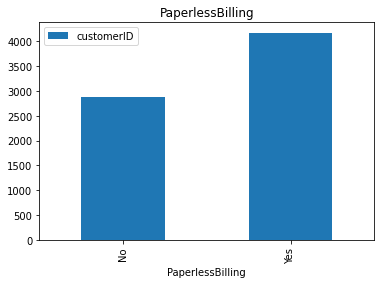

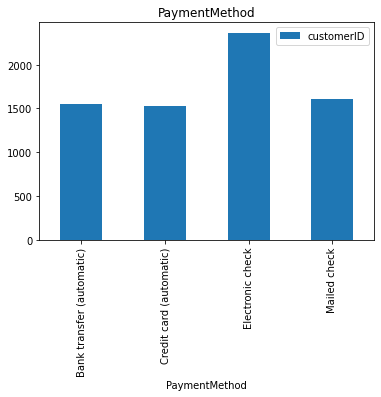

In [25]:
col = ['Type', 'PaperlessBilling', 'PaymentMethod'] # создадим список с названиями признаков
# для построения графиков для каждого через цикл
# создадим функцию для постройки графиков
def plots(df, collom):
    for i in collom:
        df.pivot_table(index=i, values='customerID', aggfunc='count').plot(kind='bar', title=i)
plots(contract, col)

Большинство предпочитает платить за услуги каждый месяц, оплата сразу за 2 года немного перегоняет оплату за 1 год. Большее количество клиентов предпочитает получать чеки на электронную почту. Самый популярный способ оплаты - электронный чек, остальные методы - банковский перевод, кредитнаяя карта и почтовый чек распологаются на одном уровне популярности.

Рассмотрим графики для таблицы с персональными данными.

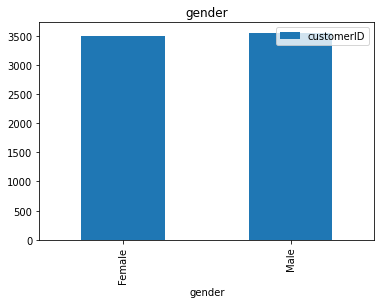

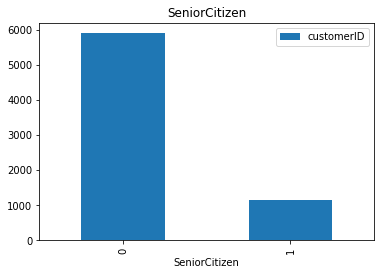

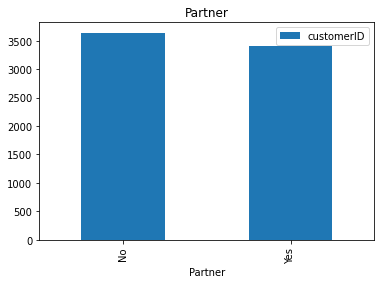

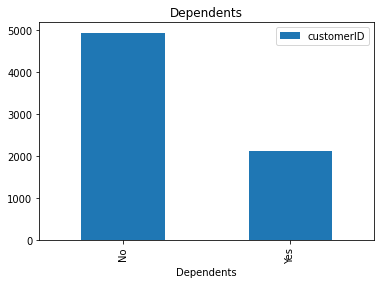

In [26]:
col = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plots(personal, col)

В нашей выборке одинаково количество мужчин и женщин, пенсионеров всего около 1200, замужние пользуются услугами на равне с холостымим, иждевенцы есть примерно у 2000 пользователей.

Рассмотрим признаки из датафрейма с интренет услугами.

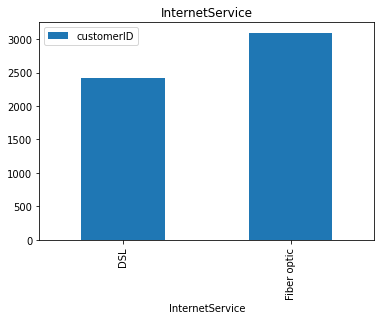

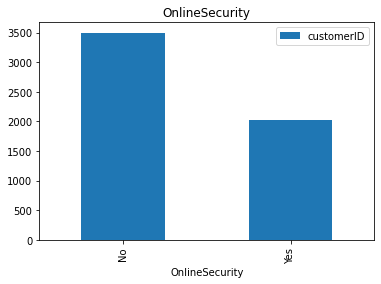

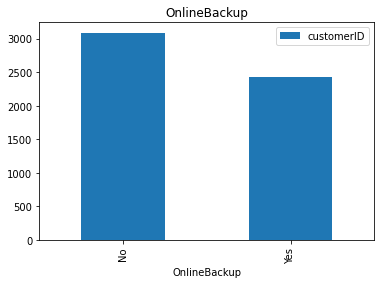

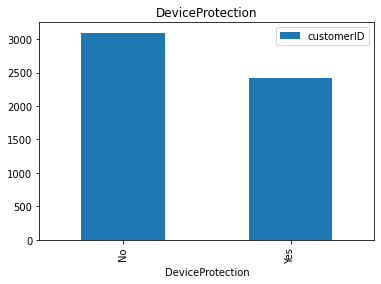

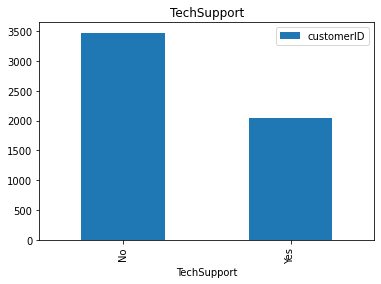

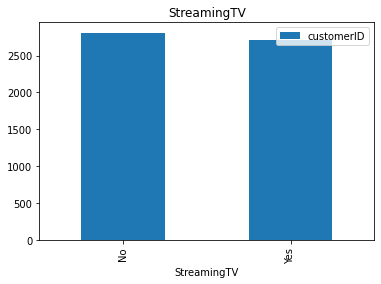

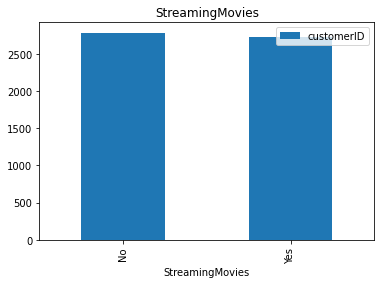

In [27]:
col = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']
plots(internet, col)

Сервис DSL немного отстает от сервиса Fiber optic по количеству пользователей, блокировка небезопасных сайтов есть у 2000 клиентов, облачным хранилищем пользуются почти 2500 тысяячи пользователей, антивирусом пользуются так же около 2500 человек, выделенной линией технической поддержки пользуется 2000 юзеров, стриминговым тв пользуется половина пользователейй подключивших интернет, так же и со каталогом стриминговых фильмов.

Теперь узнаем о наличии возможности ведения параллельных линий во время звонка.

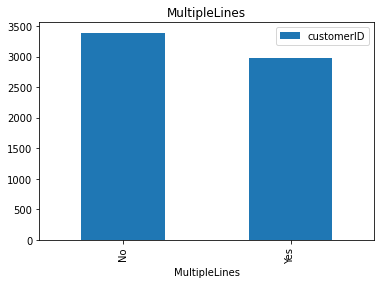

In [28]:
col = ['MultipleLines']
plots(phone, col)

3000 пользователей пользуются ведением параллельных линий во время звонка.

Соединим наши датафреймы.

In [29]:
df = 0

In [30]:
# Воспользуемся merge для левого присоединения к таблице contract
df = contract.merge(personal, on='customerID', how='left') 
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [31]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [32]:
# Заменим все пропуски на 'No'
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [33]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Присоединение прошло успешно, данные не потеряны.

Рассмотрим категориальные признаки относящиеся к интернету и телефонии после присоединения.

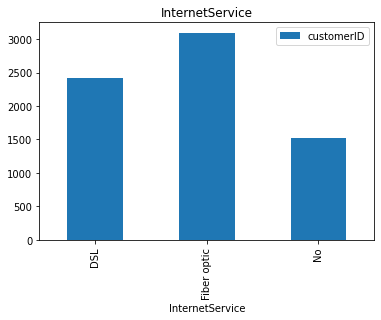

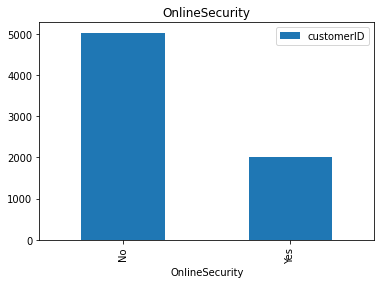

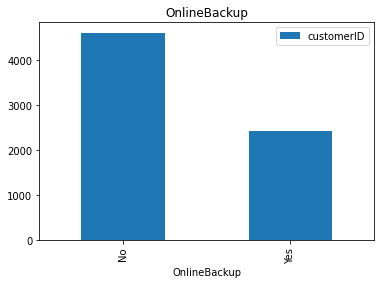

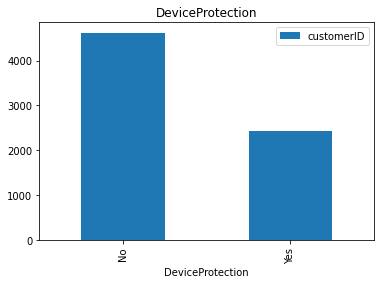

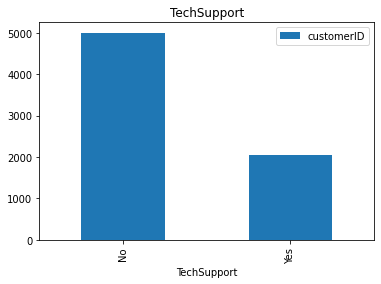

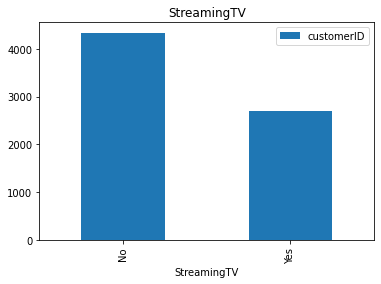

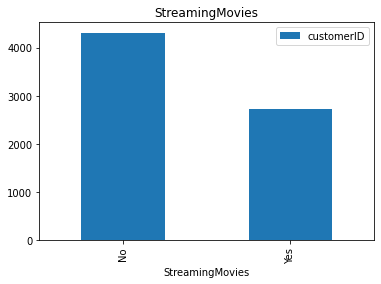

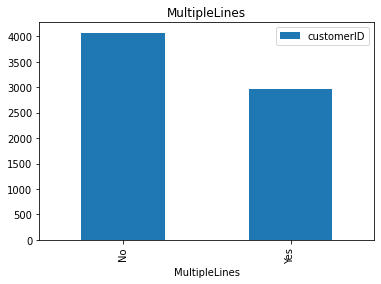

In [34]:
col = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines']
plots(df, col)

Теперь мы видим, что количество людей, которые пользуются какими либо функциями, везде меньше тех, кто ими не пользуется. Самая малопопулярная функция - OnlineSecurity, а самая популярная - MultipleLines.

Создадим целевой признак c помощью столбца EndDate.

In [35]:
df['target'] = 0
df.loc[df['EndDate'] != 'No', 'target'] = 1
df['target'].head()

0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int64

Создадим так же столбец со временем пользования услугами

In [36]:
# Заменим 'No' в EndDate последней датой из столбца BeginDate, будет считать его за последний день перед выгрузкой данных
a = df['BeginDate'].max()
df.loc[df['EndDate'] == 'No', 'EndDate'] = a
# Поменяем тип признака EndDate 
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df['diff_days'] =(df['EndDate'] - df['BeginDate']) / np.timedelta64 ( 1 , 'D')
df['diff_days']

0         31.0
1       1036.0
2         61.0
3       1371.0
4         61.0
         ...  
7038     730.0
7039    2191.0
7040     337.0
7041     123.0
7042    2010.0
Name: diff_days, Length: 7043, dtype: float64

Теперь признаки с началом и концом пользования услугами можно удалить, так же id пользователей больше не пригодятся.

In [37]:
df = df.drop(['EndDate', 'BeginDate', 'customerID'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


Проверим признаки на мультиколлинеарность.

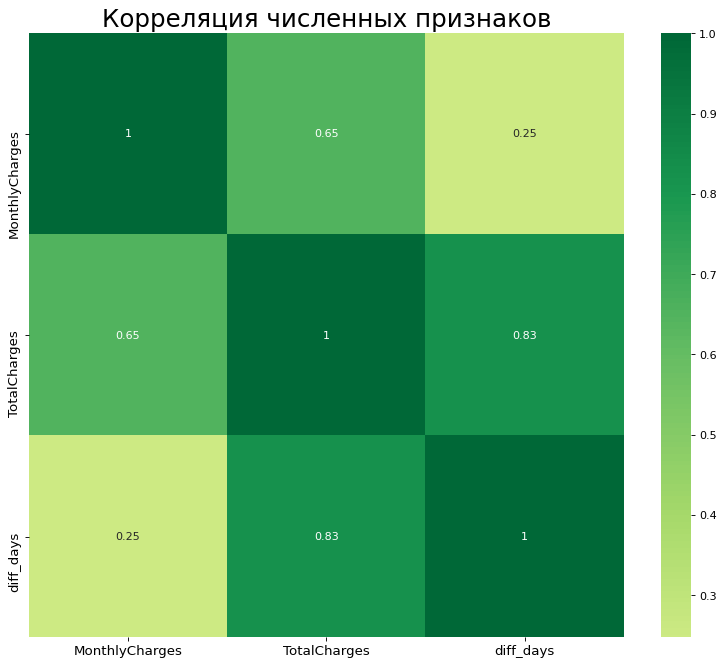

In [38]:
# Начнем с численных признаков
cor = df[['MonthlyCharges', 'TotalCharges', 'diff_days']].corr()
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Корреляция численных признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Самая большая корреляция есть между временем пользования услугами и общими затратами - чем больше вложено средств, тем больше время пользования услугами; далее идет корреляция между месячной оплатой и общими затратами, после чего незначительная корреляцция между месячными выплатами и временем пользования.

Построим матрицу корреляции для катеегориальных признаков с помощью Cramer's V

In [39]:
# Сначало закодируем данные
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in df.columns :
  data_encoded[i]=label.fit_transform(df[i])
data_encoded = data_encoded.drop(['MonthlyCharges', 'TotalCharges', 'diff_days'], axis=1)
data_encoded.head()

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
0,0,1,2,0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,0,3,1,0,0,0,0,1,0,1,0,0,0,0,0
2,0,1,3,1,0,0,0,0,1,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0
4,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,1


In [40]:
# Создадим функцию для подсчета корреляции
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

# построим матрицу
rows= []
for var1 in data_encoded:
  col = []

  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)

cramers_results = np.array(rows)
data = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

data

,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
Type,1.00,0.03,0.07,0.0,0.02,0.09,0.06,0.04,0.06,0.03,0.05,0.09,0.01,0.01,0.01,0.17
PaperlessBilling,0.03,1.00,0.06,0.0,0.02,0.00,0.01,0.14,0.00,0.02,0.01,0.00,0.05,0.04,0.03,0.04
PaymentMethod,0.07,0.06,1.00,0.0,0.04,0.03,0.02,0.10,0.03,0.04,0.04,0.03,0.06,0.06,0.05,0.09
gender,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.02,0.02,0.04,0.0,1.00,0.00,0.04,0.07,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02
Partner,0.09,0.00,0.03,0.0,0.00,1.00,0.20,0.00,0.02,0.02,0.02,0.01,0.02,0.01,0.02,0.02
Dependents,0.06,0.01,0.02,0.0,0.04,0.20,1.00,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.03
InternetService,0.04,0.14,0.10,0.0,0.07,0.00,0.03,1.00,0.16,0.15,0.14,0.15,0.20,0.20,0.14,0.10
OnlineSecurity,0.06,0.00,0.03,0.0,0.00,0.02,0.01,0.16,1.00,0.08,0.08,0.13,0.03,0.03,0.01,0.03
OnlineBackup,0.03,0.02,0.04,0.0,0.00,0.02,0.00,0.15,0.08,1.00,0.09,0.09,0.08,0.08,0.04,0.01


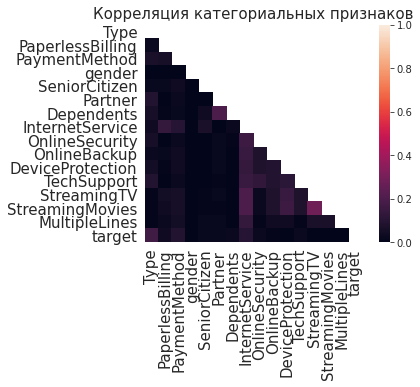

In [41]:
# сделаеем визуализацию
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(data, mask=mask,vmin=0., vmax=1, square=True)
plt.title('Корреляция категориальных признаков', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Есть небольшая корреляция междку целевым признаком и типом оплаты, так же небольшая корреляция между стримминговым тв, фильмами и сервисом интернета, корреляция между замужесством и наличием иждевенцев. Остальные признаки плохо коррелируют междку собой.

Проверим дисбаланс классов в целевом признаке.

0    0.73463
1    0.26537
Name: target, dtype: float64


<AxesSubplot:>

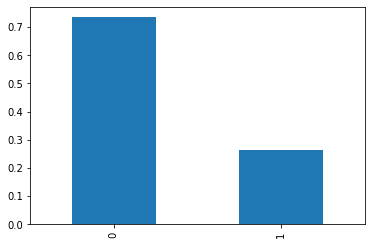

In [42]:
class_frequency = df['target'].value_counts(normalize=2/len(df['target']))
print(class_frequency)
class_frequency.plot(kind='bar') 

Имеется дисбаланс классов, только четверть пользователей перестала пользоваться услугами компании, но т.к. метрика ROC-AUC, которую мы будем рассматривать при создании модели, устойчива к дисбалансу, мы с ним ничего делать не будем.

## Построение модели

In [43]:
# Разделим наш датафрейм на выборки в соотношении 3:1
features = df.drop(['target'], axis=1)
target = df['target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)
print(features_train.info())
print(features_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 3792 to 5629
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   gender            5282 non-null   object 
 6   SeniorCitizen     5282 non-null   int64  
 7   Partner           5282 non-null   object 
 8   Dependents        5282 non-null   object 
 9   InternetService   5282 non-null   object 
 10  OnlineSecurity    5282 non-null   object 
 11  OnlineBackup      5282 non-null   object 
 12  DeviceProtection  5282 non-null   object 
 13  TechSupport       5282 non-null   object 
 14  StreamingTV       5282 non-null   object 
 15  StreamingMovies   5282 non-null   object 
 16  MultipleLines     5282 non-null   objec

In [44]:
# Создадим переменные с названием категориальных и численных признаков
categorical_features = list(features.select_dtypes(include='object').columns)
categorical_features.append('SeniorCitizen')
num_features = list(features.select_dtypes(exclude='object').columns) 
num_features.remove('SeniorCitizen')
print('категорилаьные:', categorical_features)
print('численные:', num_features)

категорилаьные: ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'SeniorCitizen']
численные: ['MonthlyCharges', 'TotalCharges', 'diff_days']


In [45]:
# Создадим датафреймы для закодированных данных
features_train_ridge = features_train.copy()
features_test_ridge = features_test.copy()

# для кодирования категориальных признаков используем One-Hot encoding
features_train_ridge = pd.get_dummies(features_train, columns = categorical_features, drop_first=True)
features_test_ridge = pd.get_dummies(features_test, columns = categorical_features, drop_first=True)
features_test_ridge.head()

# приведем признаки к единому виду
features_train_ridge, features_test_ridge = features_train_ridge.align(features_test_ridge, join='inner', axis=1)

In [46]:
# Для кодирования численных признаков используем StandardScaler
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_ridge[num_features] = scaler.fit_transform(features_train_ridge[num_features])
features_test_ridge[num_features] = scaler.transform(features_test_ridge[num_features])
features_train_ridge.head()

,MonthlyCharges,TotalCharges,diff_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,SeniorCitizen_1
3792,0.881365,0.032710,-0.257657,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,1,0,1
4005,-1.364515,-0.997495,-1.273501,0,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
1766,-1.481488,-0.749985,-0.216222,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
210,-0.630928,-0.970741,-1.233401,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3419,0.911444,1.860147,1.494672,0,1,1,0,0,1,1,...,1,0,0,1,0,1,1,0,0,0


Начнем обучение моделей, первой будет LinearRegression

In [47]:
%%time
# Создаем модель
lr = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', class_weight='balanced')

# Выбираем гиперпараметры для подбора
params = { 
    'penalty': ['l1', 'l2'],
    'C': [0.5, 1, 10, 50],
    'max_iter': [100, 1000, 2000],
    }

# используем GridSearchCV для подбора гиперпараметров
grid_lr = GridSearchCV(lr, param_grid=params, cv = 5, verbose =1, scoring='roc_auc') 
grid_lr.fit(features_train_ridge, target_train)
# Обучаем на закадированных данных
print('Лучшие параметры:', grid_lr.best_params_)
print('Лучшый счет:', grid_lr.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Лучшый счет: 0.8506613988494388
CPU times: user 25.4 s, sys: 1min 5s, total: 1min 30s
Wall time: 1min 30s


Хороший результат, посмотрим какие значения покажет CatBoost.

In [48]:
%%time
# Создаем модель
cat = CatBoostClassifier(random_state=RANDOM_STATE)

# Выбираем параметры
cat_params = {
'learning_rate': [0.6, 0.7, 0.8],
'n_estimators': range(100, 400, 100),
'depth': range(1, 5, 2),

}

grid_cat = GridSearchCV(cat, cat_params, cv=5, verbose =1, scoring='roc_auc')
# Обучать будем на незакодированных данных, CatBoost с ними справится с помощью cat_features
grid_cat.fit(features_train, target_train,
             cat_features=categorical_features, verbose=False)

print('Лучшие параметры:', grid_cat.best_params_)
print('Лучший счет:', grid_cat.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры: {'depth': 3, 'learning_rate': 0.7, 'n_estimators': 200}
Лучший счет: 0.9204874689363833
CPU times: user 47.7 s, sys: 22.9 ms, total: 47.7 s
Wall time: 1min 50s


Результаты лучше прошлых, это радует. Теперь рассмотрим RandomForestClassifier

In [49]:
%%time
# Создаем модель
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# выбираем праметры
parametrs = { 
'n_estimators': range (30, 61, 10),
'max_depth': range (1,5, 2)
}

grid_rfc = GridSearchCV(rfc, parametrs, cv=5, verbose =1, scoring='roc_auc')

# обучаем модель
grid_rfc.fit(features_train_ridge, target_train)

print('Лучшие параметры:', grid_rfc.best_params_)
print('Лучший счет:', grid_rfc.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'max_depth': 3, 'n_estimators': 60}
Лучший счет: 0.8521299258054593
CPU times: user 3.82 s, sys: 0 ns, total: 3.82 s
Wall time: 3.82 s


Лучший результат показала модель CatBoost, выведем ее на тест.

0.9109555797484907


Text(0.5, 1.0, 'ROC-кривая')

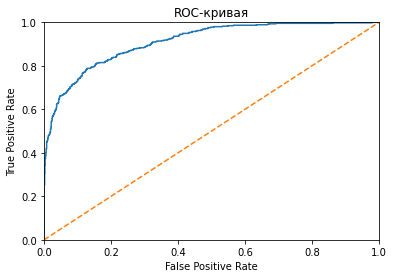

In [50]:
# Делаем предсказание на тестовых данных
probabilities_test = grid_cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print(roc_auc_score(target_test, probabilities_one_test))
# Визуализируем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title("ROC-кривая") 

Достигнуты нужные значения метрики.

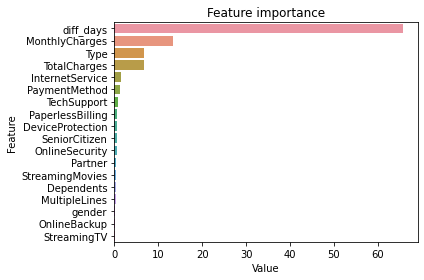

In [51]:
# Рассмотрим важность факторов 
feature_importance = grid_cat.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

В топ 3 по важности вошли - время пользования услугами, месячные выплаты и тип оплаты вместе с общими выплатами. Самые маловажные признаки - гендр, облачное хранилище и стриминговое ТВ.

## Отчет о проделанной работе

Каждый пункт плана был выполнен. Возникали трудности с признаками BeginDate и EndDate, в итоге EndDate был преобразован в целевой признак, путем замены значения 'No' на 0, а даты на 1, после чего был создан признак со временем пользования услугами(Бралась дата последнего контракта, заключенного до выгрузки данных. Из нее вычитались значения даты начала пользования услугами, так получалась время пользования услугами для тех, кто еще является пользователями услугами. Для тех, кто расторгнул контракт, просто вычиталось BeginDate из EndDate). 

Ключевые шаги выявленные в решении задачи:
- Небольшая предобработка данных(замена типов, соединение выборок, устранение пропусков, создание новых признаков)
- Исследование признаков по одному
- Исследование признаков на мультиколлериальность
- Кодирование данных, правильное выявление категориальных признаков
- Построение моделей

Для обучения были использованы все признаки кроме customerID, BeginDate, EndDate. Так же был использован новый признак - diff_days, как оказалось самый важный. Для итоговой модели были применены незакодированные признаки, которые нуждались лишь в заполнение пропусков(замена на 'No').

Финальной моделью является CatBoost - она получила лучшие показатели на валидации: 0.9204874689363833 метрики ROC-AUC. На тест она попала с такими гиперпараметрами: depth(глубина) - 3, learning_rate(коэффициент скорости обучения) - 0.7, n_estimators(количество итераций) - 200. В итоге тестирования модель показала отличные результаты - 0.9109555797484907 метрики ROC-AUC.